# 3D Simulation and fitting using physical spectral models and HESS test data release IRFs

This notebooks simulates datasets assuming spectral-cutoff power law distributions of protons, and fits with both pl and ecpl. It stores the results, so that the analysis can be done elsewhere.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
import naima
import itertools
from scipy.optimize import fsolve
from pathlib import Path
from regions import CircleSkyRegion
import multiprocessing
from joblib import Parallel, delayed

In [3]:
from gammapy.maps import WcsGeom, MapAxis, WcsNDMap
from gammapy.spectrum.models import PowerLaw, ExponentialCutoffPowerLaw, NaimaModel
from gammapy.image.models import SkyGaussian, SkyPointSource
from gammapy.cube.models import SkyModel, BackgroundModel
from gammapy.cube import MapMaker, MapDataset, PSFKernel, MapMakerRing
from gammapy.cube import make_map_exposure_true_energy, make_map_background_irf
from gammapy.utils.fitting import Fit
from gammapy.data import FixedPointingInfo
from gammapy.spectrum import FluxPointsEstimator
from gammapy.data import DataStore
from gammapy.irf import make_mean_psf, make_mean_edisp

## HESS IRFs and observation parameters

In [9]:
data_store = DataStore.from_file(
    "$GAMMAPY_DATA/hess-dl3-dr1/hess-dl3-dr3-with-background.fits.gz"
)
mask = data_store.obs_table["TARGET_NAME"] == "Crab"
obs_table = data_store.obs_table[mask]
observations = data_store.get_observations(obs_table["OBS_ID"])


# pos_crab = SkyCoord.from_name('Crab')
pos_crab = SkyCoord(83.633, 22.014, unit="deg")

In [10]:
len(observations)

4

In [11]:
obs = observations[0]

## Maps, background model and IRFs

In [12]:
aeff = obs.aeff
psf = obs.psf
edisp = obs.edisp
bkg = obs.bkg
pointing = obs.pointing_radec
livetime = 10 * u.hour

In [13]:
# Define a common map geometry
axis = MapAxis.from_edges(
    np.logspace(0, 2, 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=pointing, binsz=0.02, width=(3, 3), coordsys="GAL", axes=[axis]
)

In [14]:
exposure = make_map_exposure_true_energy(
    pointing=pointing, livetime=livetime, aeff=aeff, geom=geom
)
#exposure.slice_by_idx({"energy": 3}).plot(add_cbar=True);

In [15]:
background = make_map_background_irf(
    pointing=pointing, ontime=livetime, bkg=bkg, geom=geom
)
background_model = BackgroundModel(background)

# We freeze the background model parameters
background_model.norm.value = 1.0
background_model.tilt.value = 0.0
background_model.norm.frozen = True
background_model.tilt.frozen = True
#background.slice_by_idx({"energy": 3}).plot(add_cbar=True);

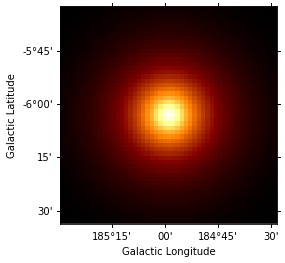

In [16]:
# We'll simulate a source at the Crab position
offset = pointing.separation(pos_crab).to(u.deg)

psf = psf.to_energy_dependent_table_psf(theta=offset)
psf_kernel = PSFKernel.from_table_psf(psf, geom, max_radius=0.5 * u.deg)
psf_kernel.psf_kernel_map.sum_over_axes().plot(stretch="log");

In [17]:
model = SkyModel(spatial_model=SkyPointSource(lon_0=pos_crab.galactic.l, lat_0=pos_crab.galactic.b), spectral_model=PowerLaw(index=1.5))


In [18]:
energy = axis.edges
edisp = edisp.to_energy_dispersion(
    offset, e_reco=energy, e_true=energy
)
#edisp.plot_matrix();

In [19]:
model = SkyModel(spatial_model=SkyPointSource(lon_0=pos_crab.galactic.l, lat_0=pos_crab.galactic.b), spectral_model=PowerLaw(index=2.5))

dataset = MapDataset(
    model=model,
    exposure=exposure,
    background_model=background_model,
    psf=psf_kernel,
    edisp=edisp,
)

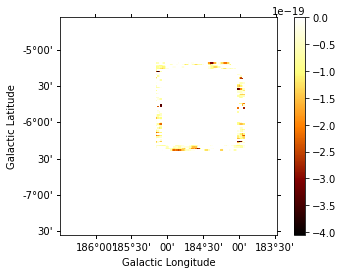

In [20]:
dataset.npred().slice_by_idx({'energy' : 7}).plot(vmax=0, add_cbar=True)
np.where(dataset.npred().data<0)
plt.savefig('psf_wrong_map.png')

In [21]:
dataset.fake()

ValueError: lam < 0